# Preprocessing

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import torch

In [4]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json


In [5]:
connection = Connection()
# Get client
client = connection.get_client()

In [6]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [7]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [8]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
W06 Record count before target preprocessing: 100
W06 Record count after target preprocessing: 100
W06 Record count after preprocessing: 100
W08 original record count: 69
W08 Record count before target preprocessing: 66
W08 Record count after target preprocessing: 66
W08 Record count after preprocessing: 66
W10 original record count: 222
W10 Record count before target preprocessing: 221
W10 Record count after target preprocessing: 221
W10 Record count after preprocessing: 221
W11 original record count: 154
W11 Record count before target preprocessing: 119
W11 Record count after target preprocessing: 119
W11 Record count after preprocessing: 119
W15 original record count: 86
W15 Record count before target preprocessing: 86
W15 Record count after target preprocessing: 86
W15 Record count after preprocessing: 86
W18 original record count: 89
W18 Record count before target preprocessing: 86
W18 Record count after target preproc

755

In [9]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          30
qg_mpfm          30
qw_mpfm          30
wc_mpfm           0
gor_mpfm         35
wgr_mpfm         36
gor_well_test     0
wgr_well_test     0
well_id           0
time_idx          0
dtype: int64

In [10]:
df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=513, Validation=81, Test=161


In [11]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [12]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.6286


In [13]:
physics_scores = model.score_physics(df_train)
physics_scores

{'W06': {'qo': {'r2': 0.5969034186263329,
   'mae': 17.503658404592848,
   'rmse': 21.82300736193082,
   'mape (%)': 20.392710493328682,
   'mpe (%)': 9.732918791805895},
  'qw': {'r2': 0.08141811152350575,
   'mae': 1.009127431010366,
   'rmse': 1.2096064526857069,
   'mape (%)': 14442.031148003753,
   'mpe (%)': 14406.614878662791},
  'qg': {'r2': 0.750777626266486,
   'mae': 1802.0466634404604,
   'rmse': 2183.5199028306865,
   'mape (%)': 12.09450063967064,
   'mpe (%)': -6.718834622281751},
  'wgr': {'r2': -0.34069577558580466,
   'mae': 6.895979578282543e-05,
   'rmse': 8.745906402720515e-05,
   'mape (%)': 535.9097418028067,
   'mpe (%)': 501.74164206800924},
  'gor': {'r2': -159.61302935178892,
   'mae': 13.930550832944144,
   'rmse': 24.962638332519727,
   'mape (%)': 11.297640251475457,
   'mpe (%)': -10.144148770526964}},
 'W08': {'qo': {'r2': -0.07636913077009999,
   'mae': 9.141686188572459,
   'rmse': 12.088057349281442,
   'mape (%)': 51.37459706642433,
   'mpe (%)': 30.

In [14]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.8776014486842787,
   'mae': 9.85545777138007,
   'rmse': 13.06489693164968,
   'mape (%)': 9.336161810053648,
   'mpe (%)': -1.6983252023405917},
  'qw': {'r2': -1.5585416031491834,
   'mae': 1.5948987091693496,
   'rmse': 2.043478855623501,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.893186870946764,
   'mae': 1385.1685516520383,
   'rmse': 1870.313479416984,
   'mape (%)': 924.067048605762,
   'mpe (%)': 908.9108399144552},
  'wgr': {'r2': -2.0388923848628764,
   'mae': 0.00013808433718840284,
   'rmse': 0.00016857956473232828,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': 0.3211586708990889,
   'mae': 17.13714277679247,
   'rmse': 27.202658101999138,
   'mape (%)': 792.5327679234614,
   'mpe (%)': 780.5063450952848}},
 'W08': {'qo': {'r2': 0.8206054287614339,
   'mae': 4.447054890605318,
   'rmse': 7.02887987059792,
   'mape (%)': 25.323037731974974,
   'mpe (%)': -8.820507128930286},
  'qw': {'r2': 0.744792973066387,
   'mae'

In [15]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9672094996517926,
   'mae': 5.042691241728184,
   'rmse': 6.762260095492269,
   'mape (%)': 3.995482188698833,
   'mpe (%)': 3.38641940427346},
  'qw': {'r2': -1.3221953137960551,
   'mae': 1.5150626455650003,
   'rmse': 1.9468087022399059,
   'mape (%)': 95.33750455060279,
   'mpe (%)': -83.62807252409975},
  'qg': {'r2': 0.8606696210888345,
   'mae': 1118.7760795752097,
   'rmse': 2136.116792203652,
   'mape (%)': 2694.5359477518787,
   'mpe (%)': 2694.5359477518787},
  'wgr': {'r2': -1.564351505082068,
   'mae': 0.00012855060895183807,
   'rmse': 0.0001548588555477522,
   'mape (%)': 96.31639185245005,
   'mpe (%)': -83.20593024795826},
  'gor': {'r2': -0.293218766963665,
   'mae': 14.50674413702856,
   'rmse': 37.54595927511995,
   'mape (%)': 2780.350601004261,
   'mpe (%)': 2777.4811241566276}},
 'W08': {'qo': {'r2': 0.9363814664665281,
   'mae': 3.1395413170787974,
   'rmse': 4.185750132791392,
   'mape (%)': 20.412995061530108,
   'mpe (%)': -15.21549721

In [16]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

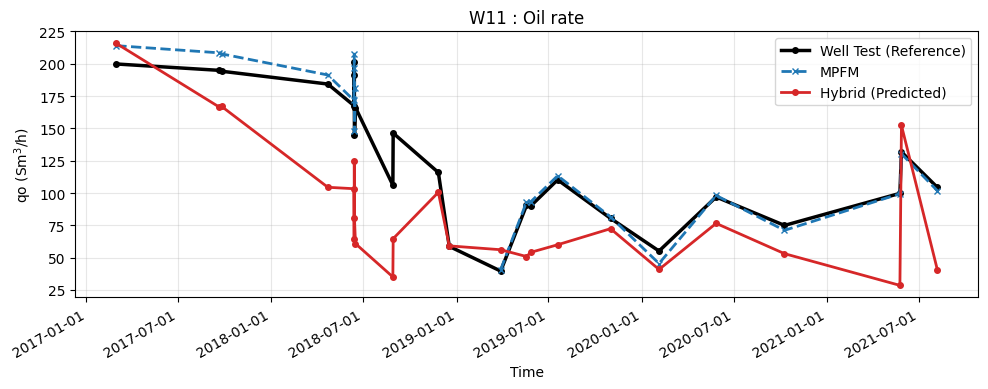

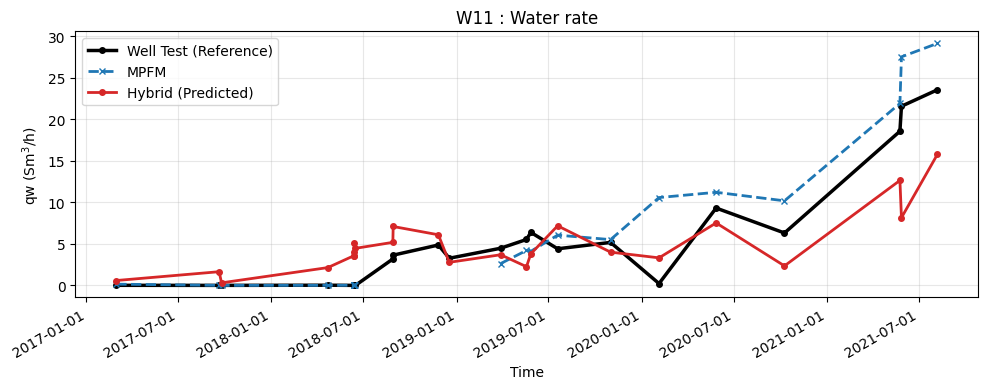

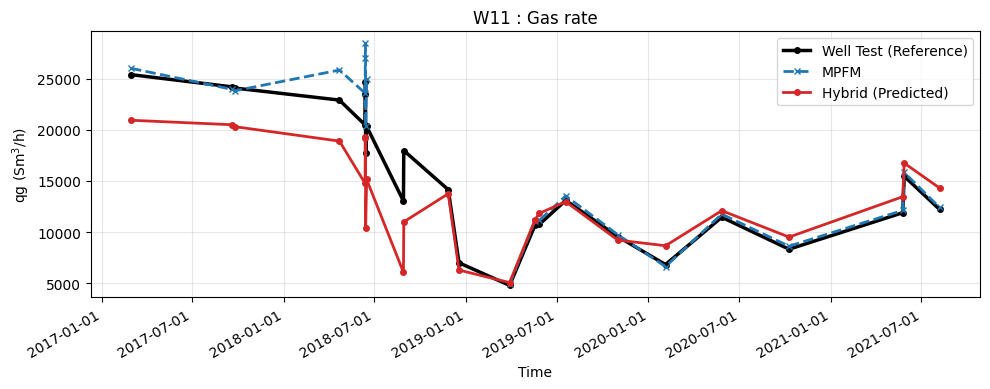

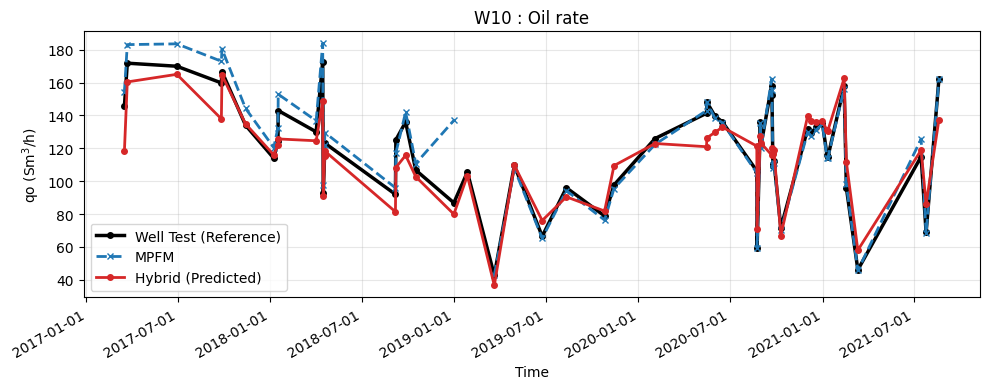

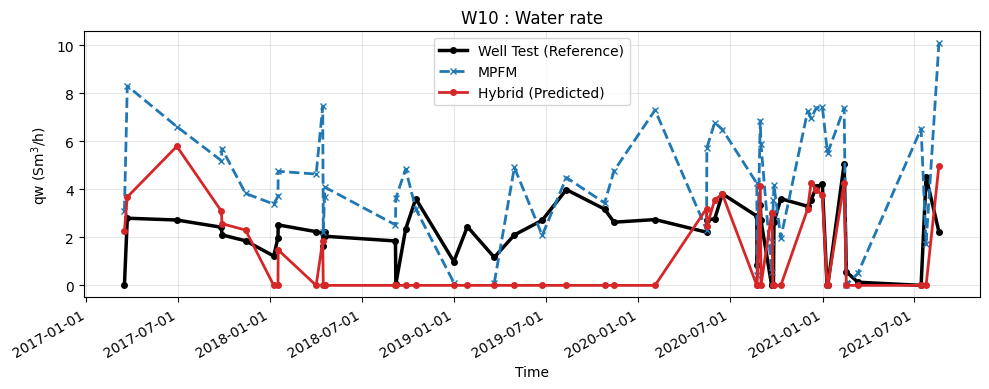

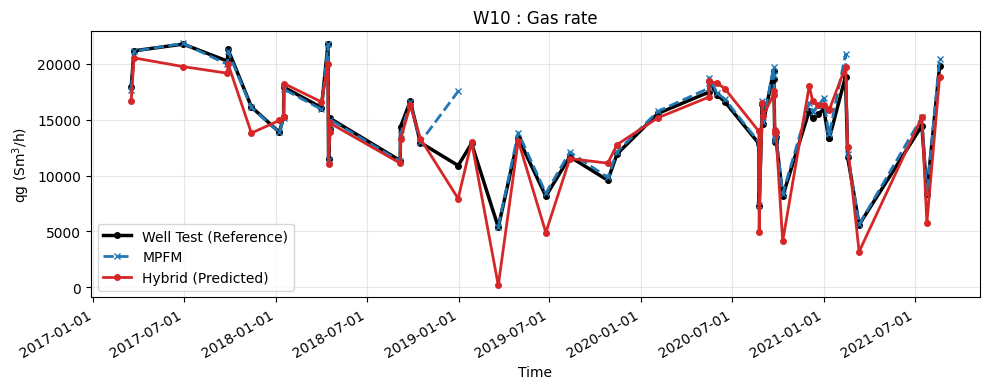

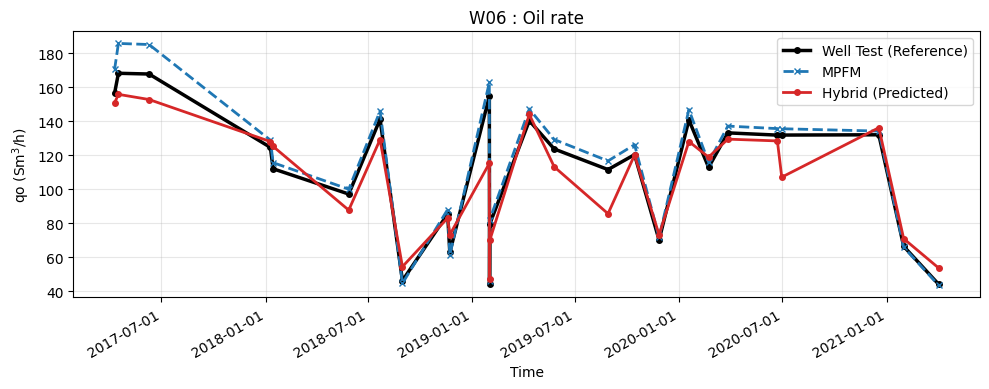

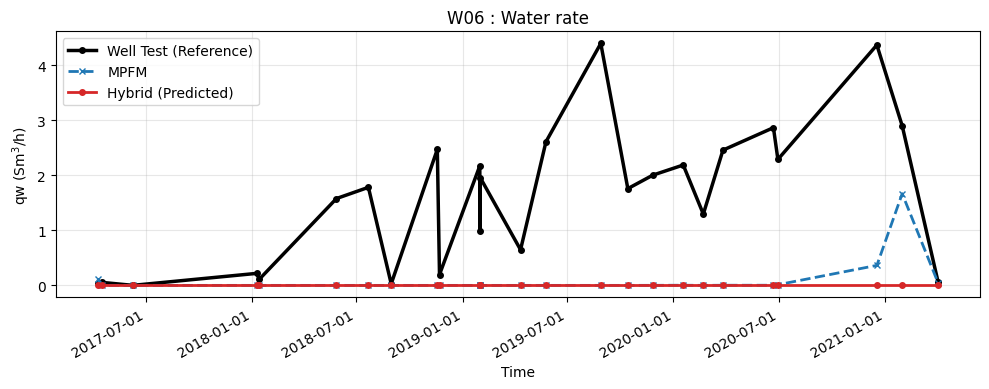

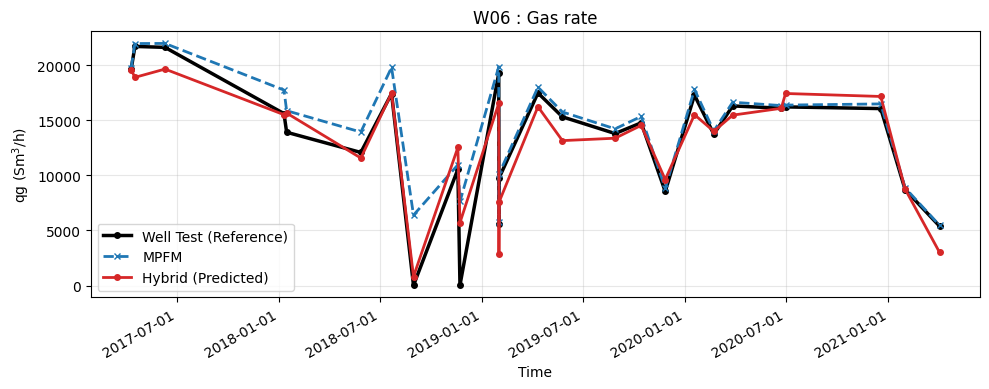

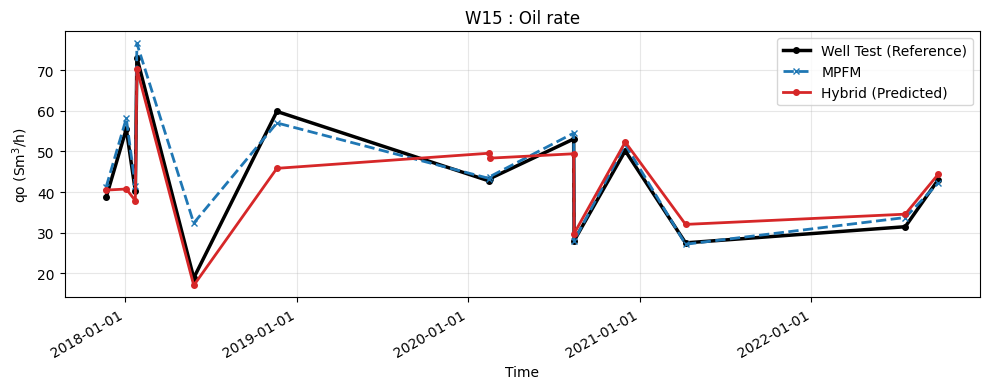

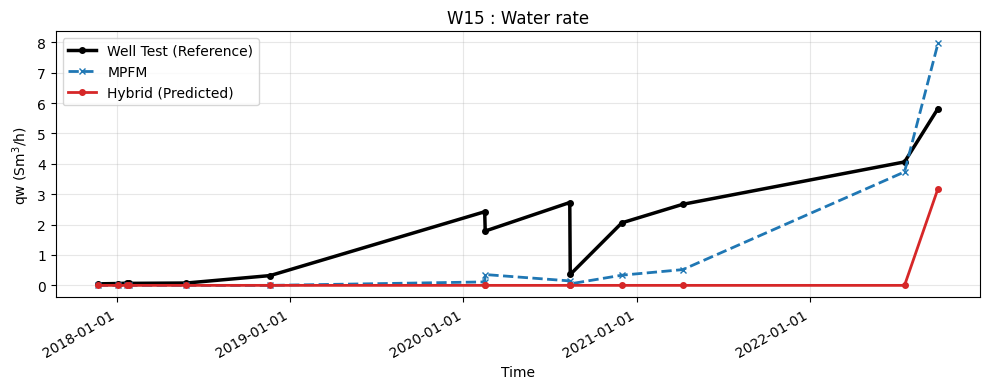

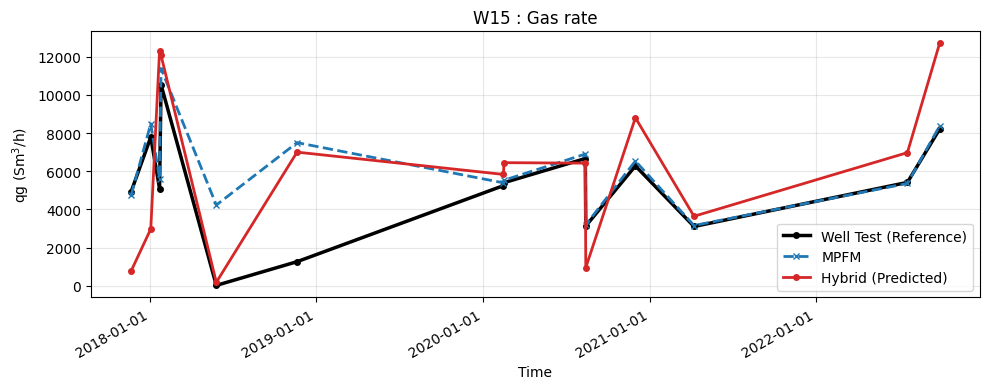

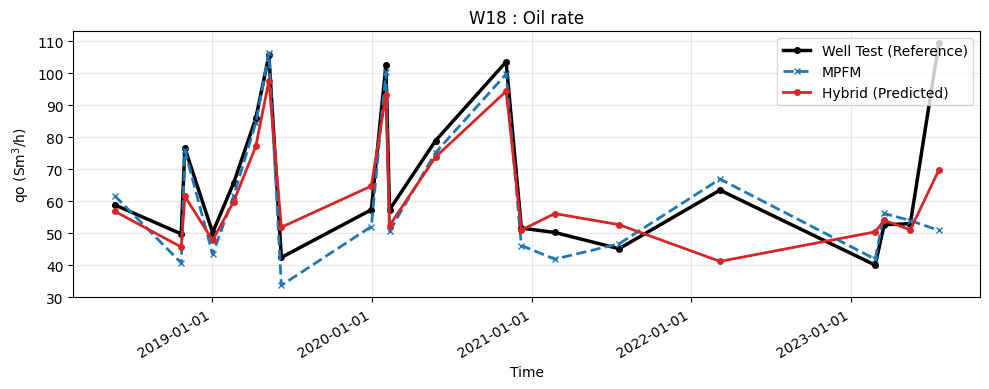

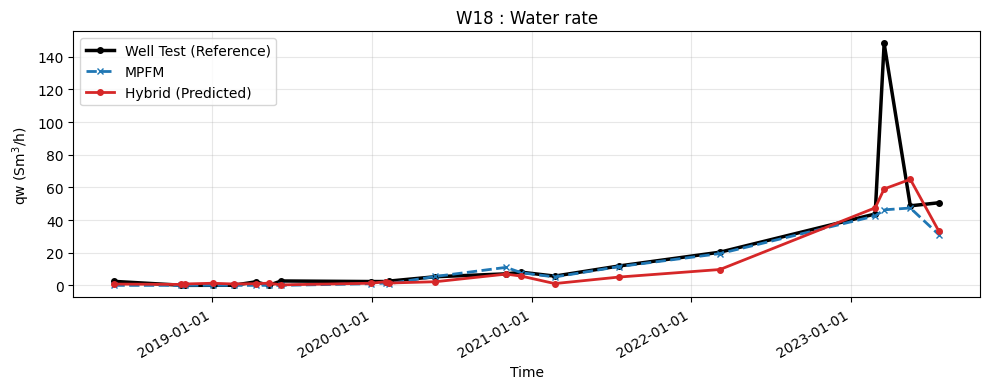

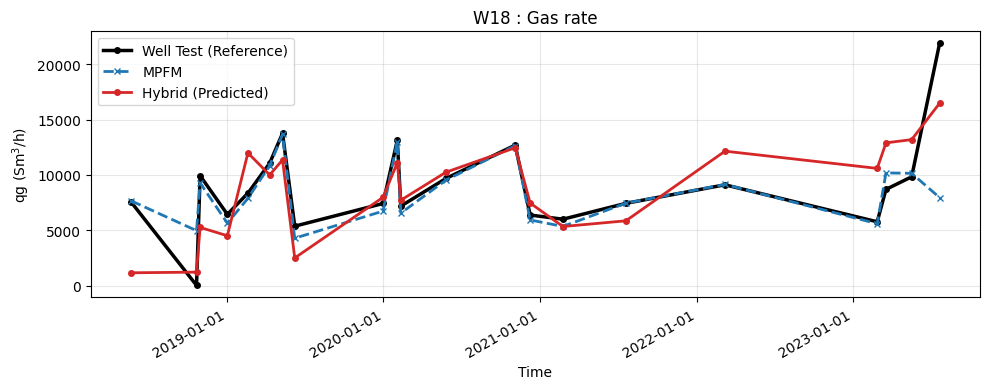

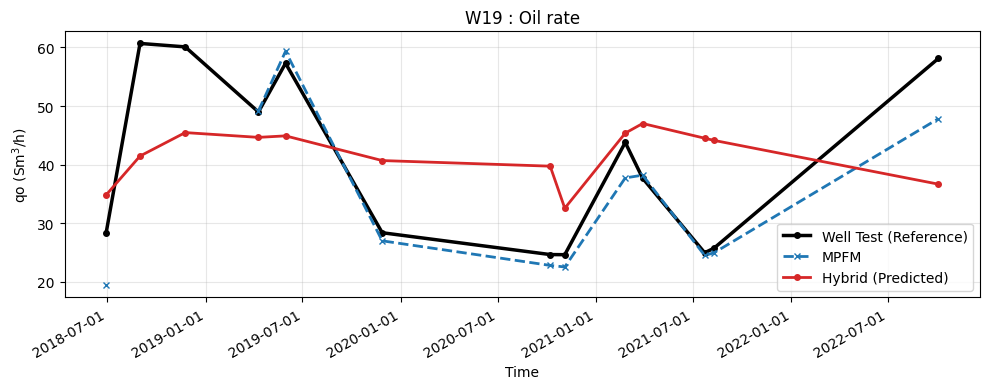

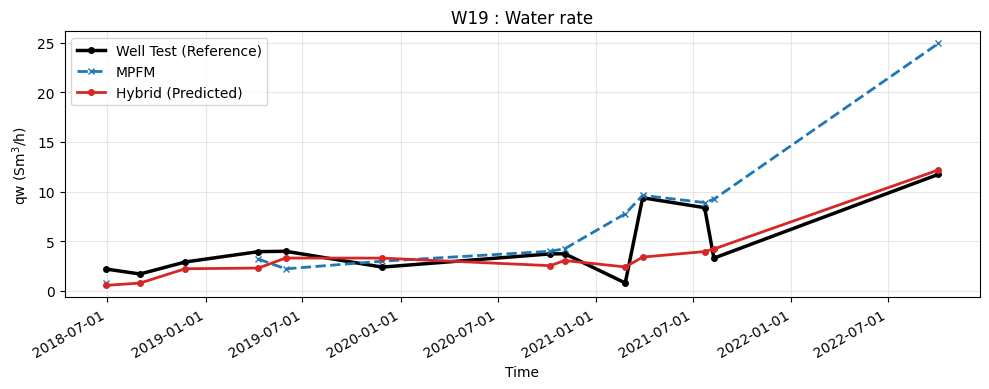

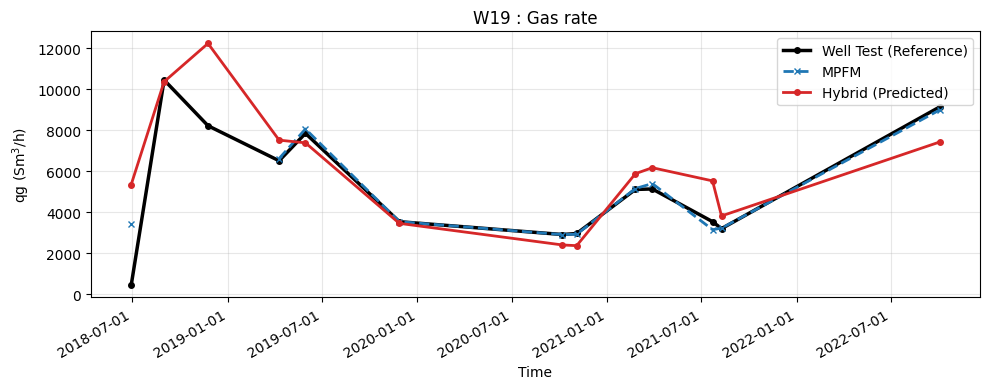

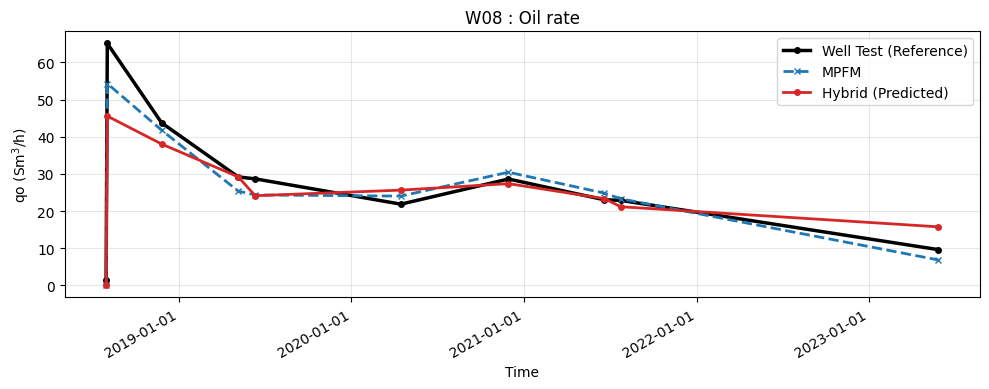

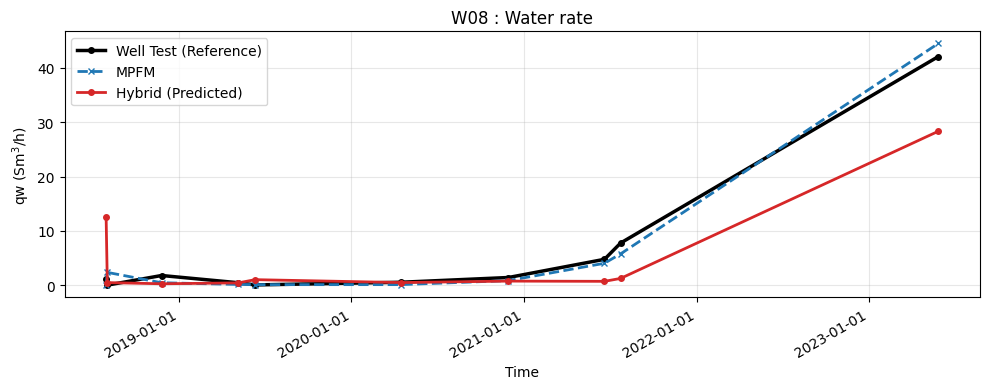

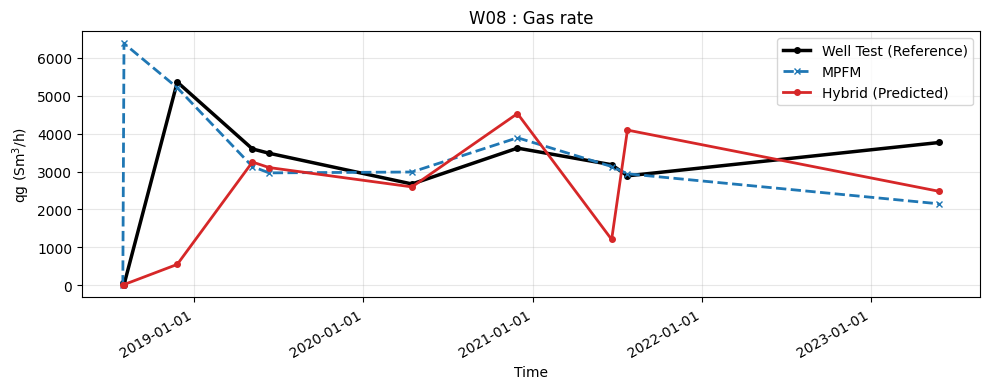

In [17]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [18]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=419, Val=115, Calibration=25, Test=196


In [19]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[Validation] Residual RMSE = 0.7410


In [20]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)

In [21]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.507969924603366,
   'mae': 16.79055281404299,
   'rmse': 22.24909458318085,
   'mape (%)': 17.60803667088281,
   'mpe (%)': 5.8960418435087805},
  'qw': {'r2': 0.5473717964157268,
   'mae': 3.5934925835988096,
   'rmse': 6.663890888451508,
   'mape (%)': 437162.11778376246,
   'mpe (%)': 437096.6875126996},
  'qg': {'r2': 0.6207419783160997,
   'mae': 1798.8860656715315,
   'rmse': 2500.743522566048,
   'mape (%)': 279.3027168962619,
   'mpe (%)': 262.6416317756076},
  'wgr': {'r2': 0.4246376083690856,
   'mae': 0.0003119252717324996,
   'rmse': 0.0006661486650756665,
   'mape (%)': 142.60065987526121,
   'mpe (%)': 73.97903812287294},
  'gor': {'r2': -0.7354826405719923,
   'mae': 12.322479122214848,
   'rmse': 20.7569600208512,
   'mape (%)': 176.8736431827533,
   'mpe (%)': 160.41525601396816}}}

In [22]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.37019933752505385,
   'mae': 20.851390943547692,
   'rmse': 25.172020333025287,
   'mape (%)': 17.71230148387984,
   'mpe (%)': 11.936508622237808},
  'qw': {'r2': 0.6915268203519218,
   'mae': 3.0789460616731197,
   'rmse': 5.501305674021301,
   'mape (%)': 158113.45173609376,
   'mpe (%)': 157990.33761788768},
  'qg': {'r2': 0.06752236033997316,
   'mae': 3106.0201549116114,
   'rmse': 3921.217914873641,
   'mape (%)': 54.22672753169727,
   'mpe (%)': 10.083775551788428},
  'wgr': {'r2': 0.537968101842242,
   'mae': 0.00026077066721786127,
   'rmse': 0.0005969478692165033,
   'mape (%)': 97.79898859202368,
   'mpe (%)': -29.49647535342902},
  'gor': {'r2': -8.438124206183652,
   'mae': 36.58963447042676,
   'rmse': 48.40569455941204,
   'mape (%)': 59.47380684452228,
   'mpe (%)': 4.147069196592796}}}

In [23]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9557097338966846,
   'mae': 4.097481688155308,
   'rmse': 6.711356501992701,
   'mape (%)': 3.402502417227931,
   'mpe (%)': 1.1435485230418259},
  'qw': {'r2': 0.9127809835569024,
   'mae': 2.5433300434499877,
   'rmse': 2.9527076392373046,
   'mape (%)': 524320.3755999898,
   'mpe (%)': 524308.0955309472},
  'qg': {'r2': 0.9370826405348629,
   'mae': 510.97498740168675,
   'rmse': 1024.2663244142311,
   'mape (%)': 448.51731905414124,
   'mpe (%)': 447.6790989503029},
  'wgr': {'r2': 0.9429771324402365,
   'mae': 0.0001701055793397172,
   'rmse': 0.0002118654904460715,
   'mape (%)': 138.89418928751934,
   'mpe (%)': 126.87224123425086},
  'gor': {'r2': 0.11882362737758057,
   'mae': 7.803924939230446,
   'rmse': 14.943461302376475,
   'mape (%)': 456.06305463835025,
   'mpe (%)': 452.18750315143313}}}

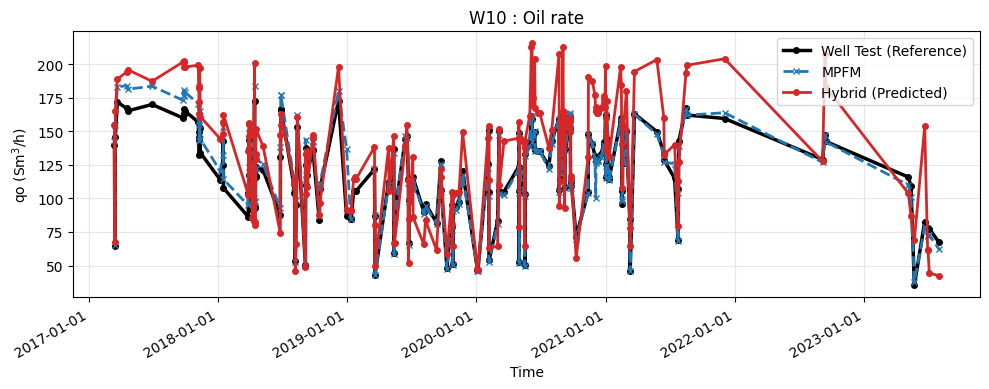

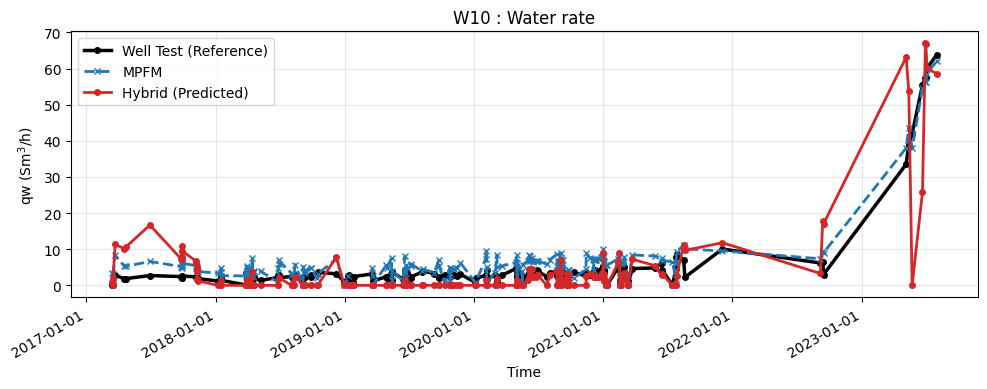

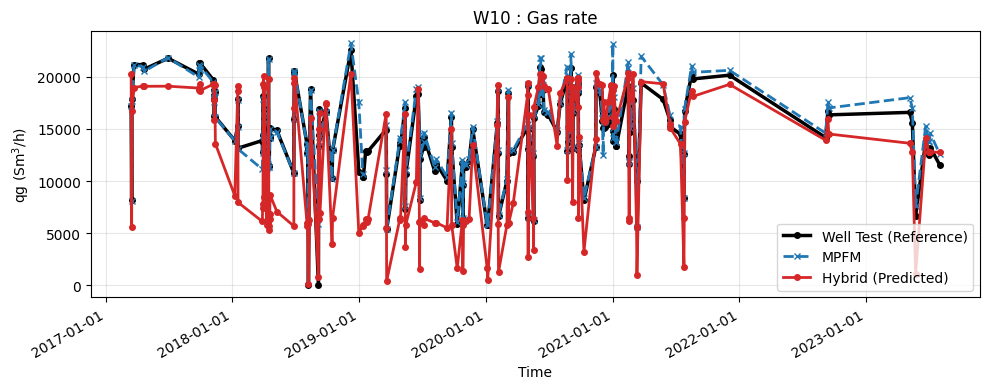

In [24]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [25]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [26]:
# df_resampled.index

In [27]:
# df_resampled.columns

In [28]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [29]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [30]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [31]:
# summarize_null(df_generated)